## CEIA - Visión por Computadora I - TP2

#### Integrantes
- Omar Victor Manuel Lopez Cabrera (a1609)
- Matías Alejandro Marando (a1615)

#### Consigna 

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que
utilizan las cámaras digitales modernas. El video a procesar será: "focus_video.mov".

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3)
    * Para cada experimento se debe presentar:
        - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuándo el 
algoritmo detectó el punto de máximo enfoque.
        - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y 
verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: "Analysis of focus measure
operators in shapefrom focus".

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

Puntos extra: Aplicar unsharp masking para expandir la zona de enfoque y devolver.

--------------

#### Resolución 

In [73]:
# Importacion de librerias
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# Función para obtener una lista de ROIs en una matriz NxM centrada en el frame con espaciado
def obtener_rois_matriz(frame, N, M, porcentaje_area=0.10):
    frame_height, frame_width = frame.shape[:2]
    area_total = frame_width * frame_height
    
    # Calcula el área total deseada (10% del área del frame o lo que diga el parametro porcentaje_area)
    area_roi_total = area_total * porcentaje_area
    
    # Calcula el área de cada ROI
    area_cada_roi = area_roi_total / (N * M)
    
    # Calcula las dimensiones de cada ROI considerando un espacio igual al tamaño de un rectángulo entre ellos
    roi_width = int(np.sqrt(area_cada_roi * (frame_width / frame_height)))
    roi_height = int(np.sqrt(area_cada_roi * (frame_height / frame_width)))
    
    # Define el espaciado entre los rectángulos (igual al tamaño del rectángulo)
    espaciado_x = roi_width
    espaciado_y = roi_height
    
    # Calcula el tamaño total ocupado por los rectángulos y sus espaciados
    total_width = M * roi_width + (M - 1) * espaciado_x
    total_height = N * roi_height + (N - 1) * espaciado_y

    # Coordenadas iniciales para centrar la matriz en el frame
    start_x = (frame_width - total_width) // 2
    start_y = (frame_height - total_height) // 2

    rois = []

    # Genera las ROIs
    for i in range(N):
        for j in range(M):
            x1 = start_x + j * (roi_width + espaciado_x)
            y1 = start_y + i * (roi_height + espaciado_y)
            x2 = x1 + roi_width
            y2 = y1 + roi_height
            roi = frame[y1:y2, x1:x2]
            rois.append(roi)

    return rois, roi_width, roi_height, start_x, start_y, espaciado_x, espaciado_y

In [75]:
# Función para calcular la calidad de enfoque segun el algoritmo del paper 
# "Image Sharpness Measure for Blurred Images in Frequency Domain"
def calcular_fm(roi):
    # Step 1: Computa la Transformada de Fourier de la ROI
    F = np.fft.fft2(roi)

    # Step 2: Centra la Transformada de Fourier
    Fc = np.fft.fftshift(F)

    # Step 3: Calcula el valor absoluto del espectro centrado
    AF = np.abs(Fc)

    # Step 4: Encuentra el valor máximo de los componentes de frecuencia
    M_val = np.max(AF)

    # Step 5: Calcula el umbral thres = M_val / 1000
    thres = M_val / 1000

    # Cuenta el número de píxeles donde el valor de AF es mayor que el umbral
    TH = np.sum(AF > thres)

    # Step 6: Calcula la medida de calidad de imagen (FM) para la ROI
    FM = TH / (roi.shape[0] * roi.shape[1])

    return FM

In [76]:
# Función principal para analizar la calidad del video
def analizar_calidad_video(video_path, N, M, porcentaje_area=0.10, UmbralFM=0.05):
    captura_video = cv.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return
    
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    delay = int(1000 / fps)

    # Lista para almacenar las medidas de calidad de imagen
    quality_measures = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convierte el frame a escala de grises
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Extrae las ROIs usando una matriz NxM centrada con espaciado
        rois, roi_width, roi_height, start_x, start_y, espaciado_x, espaciado_y = obtener_rois_matriz(gray_frame, N, M, porcentaje_area)

        # Inicializa la medida de calidad acumulada
        fm_total = 0

        # Aplica el algoritmo en cada ROI
        for roi in rois:
            # Pasos segun algoritmo del paper
            fm = calcular_fm(roi)
            
            # Acumula el valor de FM
            fm_total += fm

        # Calcula la media de la calidad en todas las ROIs
        fm_avg = fm_total / (N * M)

        # Almacena el valor promedio de FM
        quality_measures.append(fm_avg)

        # Determina el color de la grilla y el texto basado en el UmbralFM
        color = (0, 255, 0) if fm_avg >= UmbralFM else (0, 0, 255)  # Verde si fm_avg >= UmbralFM, rojo si es menor
        texto_color = (0, 255, 0) if fm_avg >= UmbralFM else (0, 0, 255)

        # Muestra el frame original con la matriz NxM marcada y los rectángulos equiespaciados
        for i in range(N):
            for j in range(M):
                x1 = start_x + j * (roi_width + espaciado_x)
                y1 = start_y + i * (roi_height + espaciado_y)
                x2 = x1 + roi_width
                y2 = y1 + roi_height
                cv.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Muestra el valor de FM en la esquina superior derecha
        cv.putText(frame, f"FM: {fm_avg:.4f}", (frame_width - 150, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, texto_color, 2)

        cv.imshow('Video con Matriz NxM', frame)

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv.destroyAllWindows()

    # Graficar la curva de calidad de imagen (FM) a lo largo del video
    plt.plot(quality_measures)
    plt.title(f'Medida de calidad de imagen (FM) en el video - Matriz {N}x{M}')
    plt.xlabel('Número de frame')
    plt.ylabel('Medida de calidad de imagen (FM)')
    plt.show()

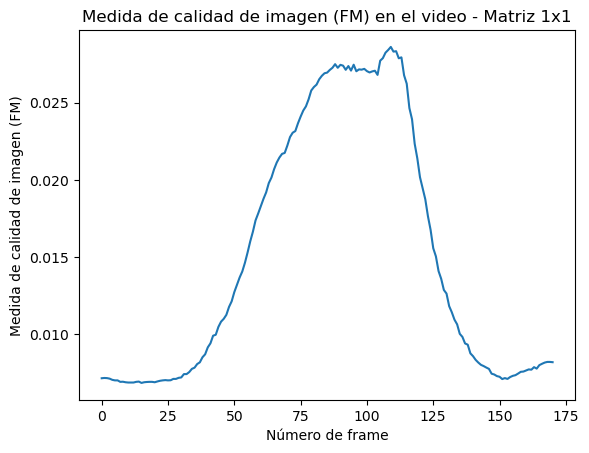

In [77]:
analizar_calidad_video('focus_video.mov', 1, 1, porcentaje_area=1, UmbralFM=0.02)

Vemos que la evolución de la medida de calidad de la imagen se corresponde al video:
- Comienza fuera de foco: FM < 0.02 en frames [0 : ~60]
- A la mitad entra en foco: FM > 0.02 en frames [~60 : ~120]
- Al final se desenfoca de nuevo: FM < 0.02 en frames [~120 : 171]

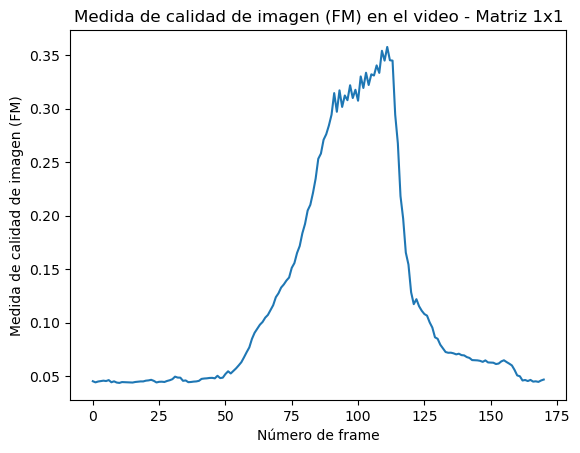

In [78]:
analizar_calidad_video('focus_video.mov', 1, 1, porcentaje_area=0.10, UmbralFM=0.15)

Vemos que, si usamos una ROI ubicada en el centro de la imagen, la cantidad de frames con 'buena calidad' es menor. Esto puede deberse a que el enfoque no es el mismo en las diferentes partes de la imagen, por lo que una medida más justa sería una que esté distribuida a lo largo de la imagen (como una cuadrícula, por ejemplo)

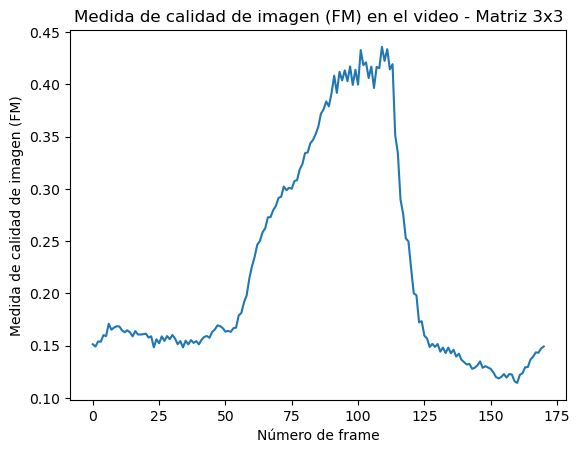

In [79]:
analizar_calidad_video('focus_video.mov', 3, 3, porcentaje_area=0.10, UmbralFM=0.22)

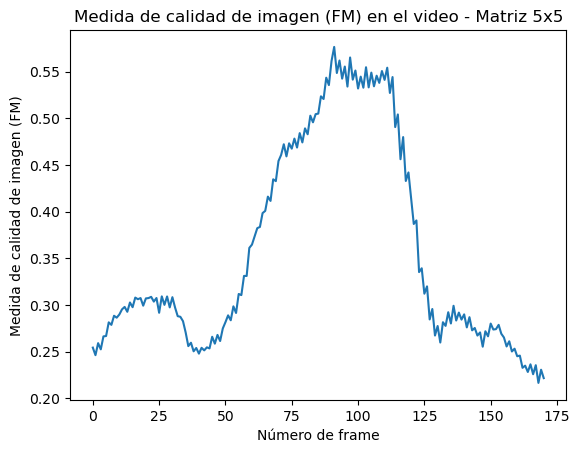

In [80]:
analizar_calidad_video('focus_video.mov', 5, 5, porcentaje_area=0.10, UmbralFM=0.35)

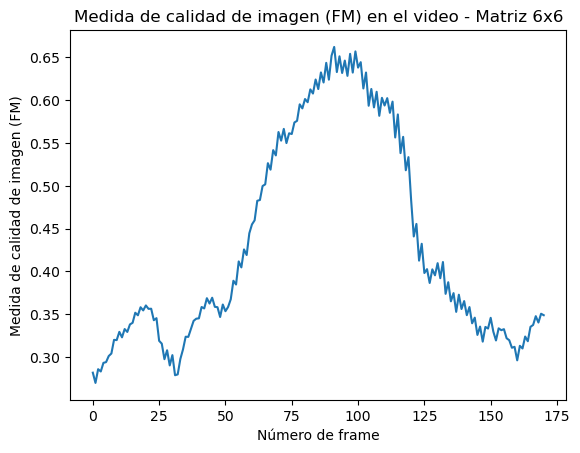

In [81]:
analizar_calidad_video('focus_video.mov', 6, 6, porcentaje_area=0.10, UmbralFM=0.40)

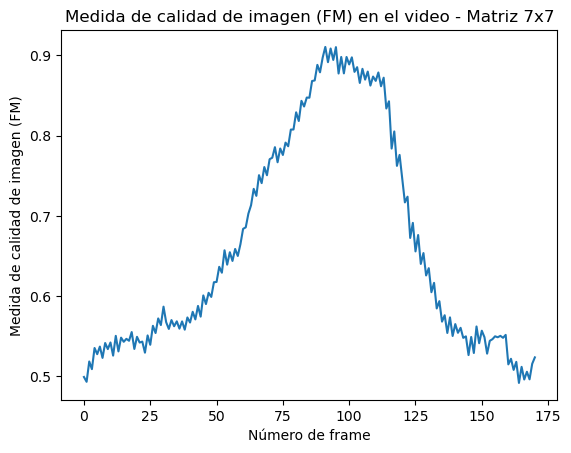

In [82]:
analizar_calidad_video('focus_video.mov', 7, 7, porcentaje_area=0.05, UmbralFM=0.7)

Vemos que el uso de matrices de enfoque permite capturar información de enfoque más detallada y localizada.

----

##### Ahora usamos otra métrica de medición de enfoque: la varianza del Laplaciano (LAP4) (https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/). El artículo que analizaba los métodos de medición de enfoque establecía que los métodos que utilizaban el Laplaciano tenían un mejor rendimiento en general.

In [83]:
# Función para medir la calidad de enfoque utilizando el operador Laplaciano
def calcular_laplacian_fm(roi):
    # Se aplica el operador Laplaciano a la ROI y calcula la varianza
    laplacian = cv.Laplacian(roi, cv.CV_64F)
    fm = laplacian.var()
    return fm

# Función principal para analizar la calidad del video usando Laplacian FM
def analizar_calidad_video_laplaciano(video_path, N, M, porcentaje_area=0.10, UmbralFM=100.0):
    captura_video = cv.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return
    
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    delay = int(1000 / fps)
    
    # Lista para almacenar las medidas de calidad de imagen
    quality_measures = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Se Convierte el frame a escala de grises
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Se Extrae las ROIs usando una matriz NxM centrada con espaciado
        rois, roi_width, roi_height, start_x, start_y, espaciado_x, espaciado_y = obtener_rois_matriz(gray_frame, N, M, porcentaje_area)

        fm_total = 0

        #Se aplica el operador Laplaciano en cada ROI
        for roi in rois:
            fm = calcular_laplacian_fm(roi)  # Calcula la medida de enfoque (FM)
            fm_total += fm  # Acumula el valor de FM

        # Calcula la media de la calidad en todas las ROIs
        fm_avg = fm_total / (N * M)

        # Almacena el valor promedio de FM
        quality_measures.append(fm_avg)

        # Determina el color de la grilla y el texto basado en el UmbralFM
        color = (0, 255, 0) if fm_avg >= UmbralFM else (0, 0, 255)  # Verde si fm_avg >= UmbralFM, rojo si es menor
        texto_color = (0, 255, 0) if fm_avg >= UmbralFM else (0, 0, 255)

        # Muestra el frame original con la matriz NxM marcada y los rectángulos equiespaciados
        for i in range(N):
            for j in range(M):
                x1 = start_x + j * (roi_width + espaciado_x)
                y1 = start_y + i * (roi_height + espaciado_y)
                x2 = x1 + roi_width
                y2 = y1 + roi_height
                cv.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Muestra el valor de FM en la esquina superior derecha
        cv.putText(frame, f"FM: {fm_avg:.4f}", (frame_width - 150, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, texto_color, 2)

        cv.imshow('Video con Matriz NxM - Laplaciano', frame)

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv.destroyAllWindows()

    # Graficar la curva de calidad de imagen (FM) a lo largo del video
    plt.plot(quality_measures)
    plt.title(f'Medida de calidad de imagen (FM) en el video - Laplaciano {N}x{M}')
    plt.xlabel('Número de frame')
    plt.ylabel('Medida de calidad de imagen (FM)')
    plt.show()

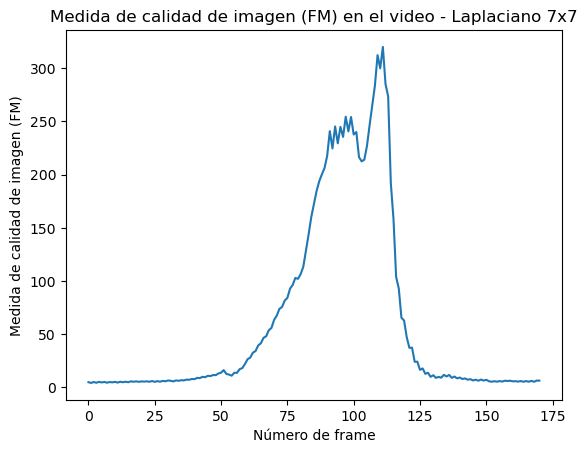

In [84]:
analizar_calidad_video_laplaciano('focus_video.mov', 7, 7, porcentaje_area=0.10, UmbralFM=100.0)

Vemos que la respuesta de este algoritmo tiene mucho menor ruido que el que utilizamos en la sección anterior para la misma matriz de enfoque.

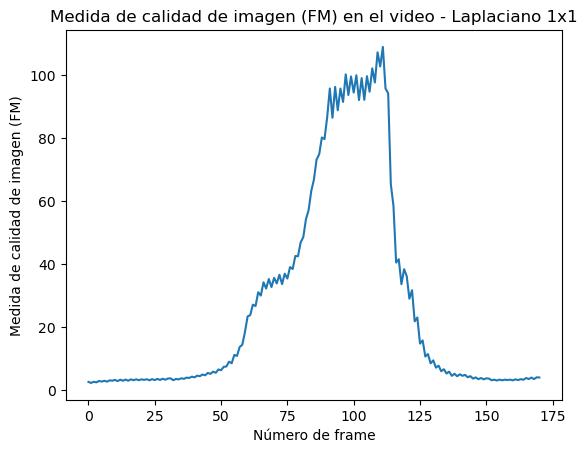

In [85]:
analizar_calidad_video_laplaciano('focus_video.mov', 1, 1, porcentaje_area=1, UmbralFM=40.0)

----

##### Extra: unsharp masking

In [86]:
# Función de unsharp mask
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [87]:
# Función principal para analizar la calidad del video usando Laplacian FM con unsharp mask aplicado si es necesario
def analizar_calidad_video_laplaciano_unsharp(video_path, UmbralFM=100.0, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    captura_video = cv.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return
    
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    delay = int(1000 / fps)
    
    # Listas para almacenar las medidas de calidad de imagen
    quality_measures_pre_unsharp = []
    quality_measures_post_unsharp = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convierte el frame a escala de grises
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Medición FM antes del unsharp mask
        fm_avg_pre = calcular_laplacian_fm(gray_frame)
        quality_measures_pre_unsharp.append(fm_avg_pre)

        # Si FM es menor que el umbral, aplicar el unsharp masking a todo el frame
        if fm_avg_pre < UmbralFM:
            frame = unsharp_mask(frame, kernel_size=kernel_size, sigma=sigma, amount=amount, threshold=threshold)

        # Medición FM después del unsharp mask
        gray_frame_post_unsharp = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        fm_avg_post = calcular_laplacian_fm(gray_frame_post_unsharp)
        quality_measures_post_unsharp.append(fm_avg_post)

        # Determina el color del texto basado en el UmbralFM
        texto_color = (0, 255, 0) if fm_avg_post >= UmbralFM else (0, 0, 255)

        # Muestra el valor de FM en la esquina superior derecha
        cv.putText(frame, f"FM: {fm_avg_post:.4f}", (frame_width - 150, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, texto_color, 2)

        cv.imshow('Video - Laplaciano (1x1)', frame)

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv.destroyAllWindows()

    # Graficar las curvas de calidad de imagen (FM) antes y después del unsharp mask
    plt.plot(quality_measures_pre_unsharp, label='Pre Unsharp Mask', color='blue')
    plt.plot(quality_measures_post_unsharp, label='Post Unsharp Mask', color='green')
    plt.title('Medida de calidad de imagen (FM) - Pre y Post Unsharp Mask')
    plt.xlabel('Número de frame')
    plt.ylabel('Medida de calidad de imagen (FM)')
    plt.legend()
    plt.show()


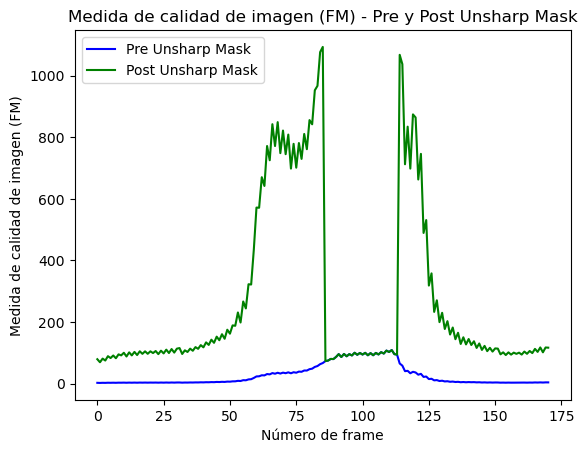

In [88]:
analizar_calidad_video_laplaciano_unsharp('focus_video.mov', UmbralFM=70, kernel_size=(5, 5), sigma=1.0, amount=5, threshold=0)

Vemos que cuando el video está en foco se deja de aplicar el unsharp mask (frame ~80), por eso se ve la caída abrupta en la FM de "Post Unsharp Mask" en ese punto.